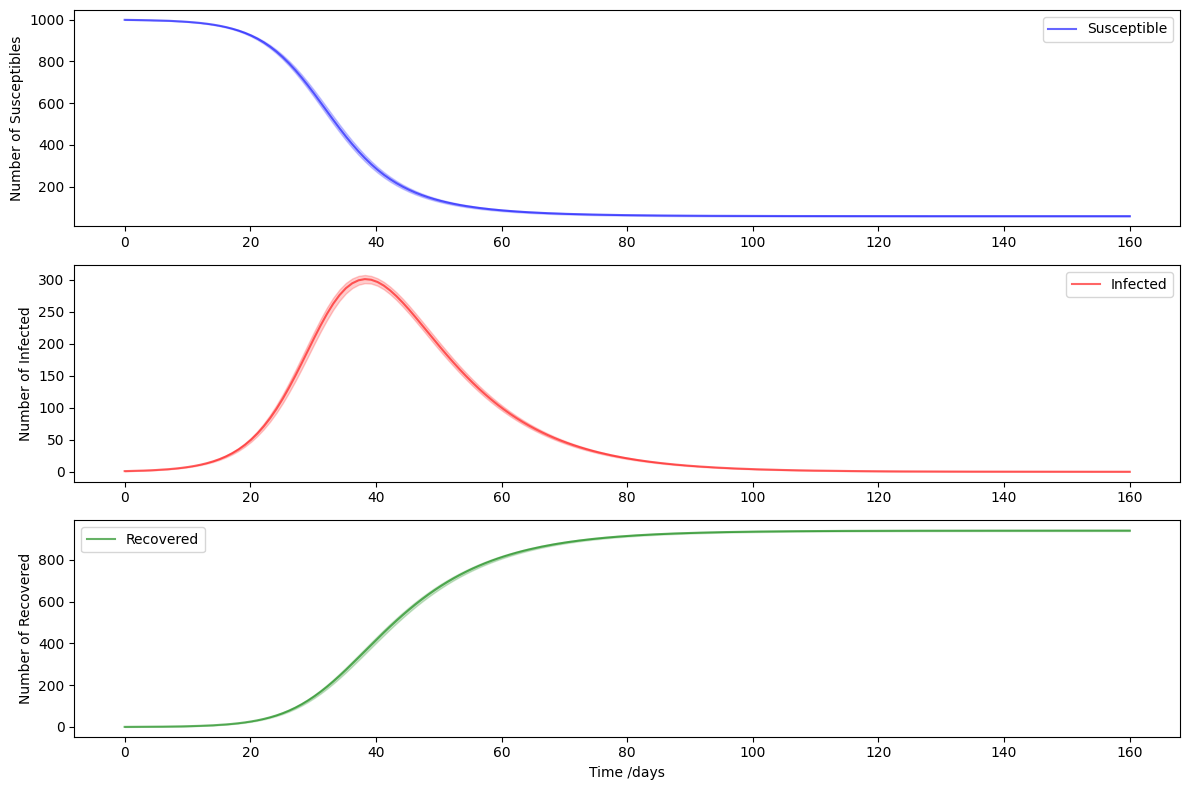

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Parameters
beta_0 = 0.3   # base infection rate
gamma_0 = 0.1  # base recovery rate
N = 1000       # total population
I0 = 1         # initial number of infected individuals
R0 = 0         # initial number of recovered individuals
S0 = N - I0 - R0  # initial number of susceptible individuals
t = np.linspace(0, 160, 160)  # time grid

# Number of Monte Carlo simulations
num_simulations = 1000

# Function to compute derivatives
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Store results of each simulation
results = []

for _ in range(num_simulations):
    # Introduce stochasticity
    beta_t = beta_0 * (1 + np.random.normal(0, 0.05, size=len(t)))
    gamma_t = gamma_0 * (1 + np.random.normal(0, 0.05, size=len(t)))

    # Solve ODEs for each time step with varying beta and gamma
    y0 = S0, I0, R0
    sol = np.empty((len(t), 3))
    sol[0] = y0

    for i in range(1, len(t)):
        t_span = [t[i-1], t[i]]
        beta = beta_t[i-1]
        gamma = gamma_t[i-1]
        y = odeint(deriv, sol[i-1], t_span, args=(beta, gamma))
        sol[i] = y[1]

    results.append(sol)

# Convert results to numpy array for easier manipulation
results = np.array(results)

# Calculate mean and standard deviation for each compartment
mean_S = np.mean(results[:, :, 0], axis=0)
mean_I = np.mean(results[:, :, 1], axis=0)
mean_R = np.mean(results[:, :, 2], axis=0)
std_S = np.std(results[:, :, 0], axis=0)
std_I = np.std(results[:, :, 1], axis=0)
std_R = np.std(results[:, :, 2], axis=0)

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, mean_S, 'b', alpha=0.6, label='Susceptible')
plt.fill_between(t, mean_S - std_S, mean_S + std_S, color='b', alpha=0.2)
plt.ylabel('Number of Susceptibles')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, mean_I, 'r', alpha=0.6, label='Infected')
plt.fill_between(t, mean_I - std_I, mean_I + std_I, color='r', alpha=0.2)
plt.ylabel('Number of Infected')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, mean_R, 'g', alpha=0.6, label='Recovered')
plt.fill_between(t, mean_R - std_R, mean_R + std_R, color='g', alpha=0.2)
plt.xlabel('Time /days')
plt.ylabel('Number of Recovered')
plt.legend()

plt.tight_layout()
plt.show()


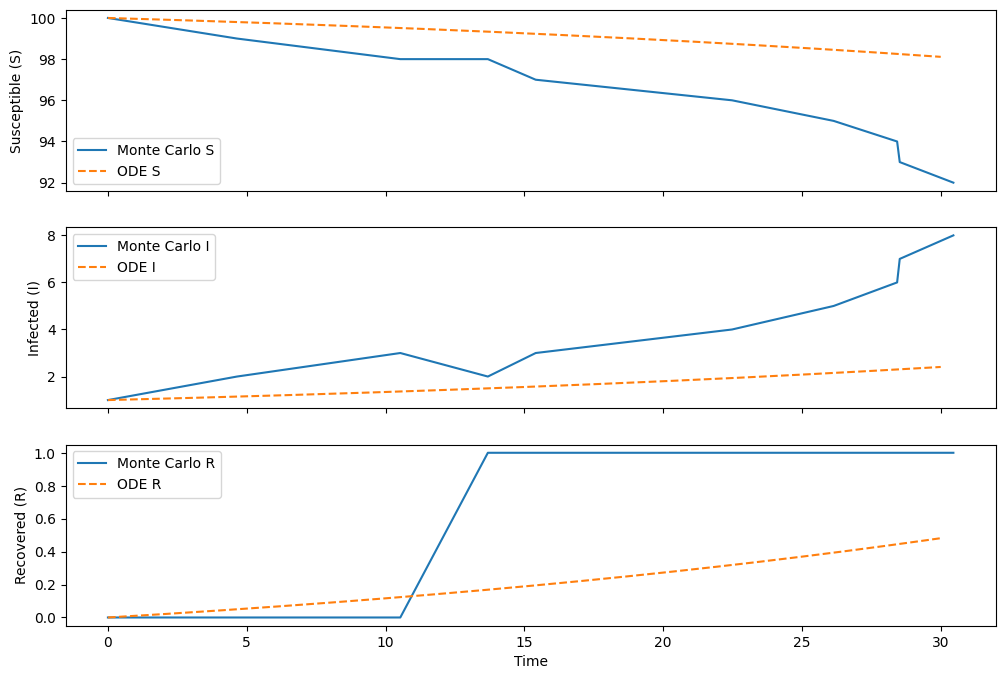

Monte Carlo Simulation Data:
        Time    S  I  R
0   0.000000  100  1  0
1   4.648846   99  2  0
2  10.532278   98  3  0
3  13.686120   98  2  1
4  15.409149   97  3  1
5  22.483014   96  4  1
6  26.142900   95  5  1
7  28.428584   94  6  1
8  28.523297   93  7  1
9  30.455452   92  8  1

ODE Simulation Data:
         Time           S         I         R
0     0.00000  100.000000  1.000000  0.000000
1     0.03003   99.998810  1.000889  0.000300
2     0.06006   99.997619  1.001780  0.000601
3     0.09009   99.996427  1.002671  0.000902
4     0.12012   99.995234  1.003562  0.001203
..        ...         ...       ...       ...
995  29.87988   98.122505  2.398921  0.478574
996  29.90991   98.119704  2.401001  0.479295
997  29.93994   98.116901  2.403082  0.480016
998  29.96997   98.114096  2.405166  0.480738
999  30.00000   98.111288  2.407251  0.481461

[1000 rows x 4 columns]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
import pandas as pd

# Parameters
S0 = 100
I0 = 1
R0 = 0
tend = 30
beta = 0.04
gamma = 0.01

# Gillespie Algorithm (Monte Carlo simulation)
S = [S0]
I = [I0]
R = [R0]
t = [0]

while t[-1] < tend and (S[-1] + I[-1] >= 1):
    N = S[-1] + I[-1] + R[-1]
    props = [beta * I[-1] * S[-1] / N, gamma * I[-1]]
    prop_sum = sum(props)
    tau = np.random.exponential(scale=1 / prop_sum)
    t.append(t[-1] + tau)
    rand = random.uniform(0, 1)

    if rand * prop_sum <= props[0]:  # Susceptible becomes Infected
        S.append(S[-1] - 1)
        I.append(I[-1] + 1)
        R.append(R[-1])
    else:  # Infected becomes Recovered
        S.append(S[-1])
        I.append(I[-1] - 1)
        R.append(R[-1] + 1)

# Collecting Monte Carlo data
mc_data = pd.DataFrame({"Time": t, "S": S, "I": I, "R": R})

# ODE simulation
t_ode = np.linspace(0, tend, num=1000)
y0 = [S0, I0, R0]
params = [beta, gamma]

def sim(variables, t, params):
    S, I, R = variables
    N = S + I + R
    beta, gamma = params
    dSdt = -beta * I * S / N
    dIdt = beta * I * S / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

y_ode = odeint(sim, y0, t_ode, args=(params,))
ode_data = pd.DataFrame({"Time": t_ode, "S": y_ode[:, 0], "I": y_ode[:, 1], "R": y_ode[:, 2]})

# Plotting
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 8))
ax1.plot(mc_data["Time"], mc_data["S"], label='Monte Carlo S')
ax1.plot(ode_data["Time"], ode_data["S"], label='ODE S', linestyle='dashed')
ax2.plot(mc_data["Time"], mc_data["I"], label='Monte Carlo I')
ax2.plot(ode_data["Time"], ode_data["I"], label='ODE I', linestyle='dashed')
ax3.plot(mc_data["Time"], mc_data["R"], label='Monte Carlo R')
ax3.plot(ode_data["Time"], ode_data["R"], label='ODE R', linestyle='dashed')

ax1.set_ylabel("Susceptible (S)")
ax2.set_ylabel("Infected (I)")
ax3.set_ylabel("Recovered (R)")
ax3.set_xlabel("Time")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# Output detailed data at each step
print("Monte Carlo Simulation Data:")
print(mc_data)
print("\nODE Simulation Data:")
print(ode_data)
